# Train DDC Model for Conditional Generation

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from datasets.data_loader import *
from models.ddc import SMILESGenerator
from models.loss import InfoNCELoss
from models.trfm import *
from utils.utils import *
from utils.plot_figures import *
from utils.metrics import *
from utils.build_vocab import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
train_ce_loss_history = []
test_ce_loss_history = []
train_info_loss_history = []
test_info_loss_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# read the data from the file
train_data = pd.read_csv('./data/train_contrastive_dataset.csv')
test_data = pd.read_csv('./data/test_contrastive_dataset.csv')

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

charlen = len(vocab)
print('the total num of charset is :', charlen)

the vocab size is : 45
the total num of charset is : 45


In [6]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
epoch = 20
InfoNCEloss_weight = 0.1

In [7]:
# create the dataset and dataloader
# train_dataset = Contrastive_Seq2seqDataset(train_data, vocab, MAX_LEN)
# test_dataset = Contrastive_Seq2seqDataset(test_data, vocab, MAX_LEN)
train_dataset = Contrastive_Seq2seqDataset_random(train_data, vocab, MAX_LEN)
test_dataset = Contrastive_Seq2seqDataset_random(test_data, vocab, MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# create the model
model = SMILESGenerator(condition_dim=24, lstm_dim=256, dec_layers=3, charset_size=charlen).to(device)

# load model
trfm = TrfmSeq2seq(charlen, 256, charlen, 4).to(device)
trfm.load_state_dict(torch.load('./model_hub/trfm_new_2_10000.pkl'))
trfm.eval()

# set trfm gradient to false which won't be updated
for param in trfm.parameters():
    param.requires_grad = False

# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=PAD)
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

100%|██████████| 14803/14803 [00:00<00:00, 51203.54it/s]


total parameters: 1.41M


In [8]:
# train function
def train(model, trfm, train_dataloader, loss_func, optim, device, weight=0.1):
    model.train()
    total_loss = 0
    total_loss_crossentropy = 0
    total_loss_infonce = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        positive_smiles = positive_smiles.to(device)
        negative_smiles = negative_smiles.to(device)
        
        # concat zeo and syn as the input (prop)
        synthesis_condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # convert the tgt_input to one-hot
        tgt_input = F.one_hot(tgt_input, num_classes=charlen).float()
        
        optim.zero_grad()
        logits = model(synthesis_condition, tgt_input)
        
        # Compute CrossEntropy Loss
        logits_reshaped = logits.view(-1, logits.size(-1))
        tgt_label_reshaped = tgt_label.view(-1)
        loss_ce = loss_func(logits_reshaped, tgt_label_reshaped)
        
        # calculate the accuracy
        pred = torch.argmax(logits, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != PAD)
        num_words = (tgt_label != PAD).sum().item()
        
        # Gumbel-Softmax Sampling
        # logits: [batch_size, seq_len, vocab_size]
        samples = F.gumbel_softmax(logits, tau=1.0, hard=True)
        samples_indices = samples.argmax(dim=-1) # [batch_size, seq_len]
        # add the start token to the samples
        stared_token = torch.ones(samples_indices.size(0), 1, dtype=torch.long).fill_(SOS).to(device)
        samples_indices = torch.cat([stared_token, samples_indices], dim=-1)
        
        # Compute InfoNCE Loss
        loss_infonce = InfoNCELoss(samples_indices, positive_smiles, negative_smiles, trfm, temperature=0.07)
        
        # combine the two loss
        loss = loss_ce + weight * loss_infonce
        
        # backward
        loss.backward()
        optim.step()
        
        # statistics
        total_loss += loss.item()
        total_loss_crossentropy += loss_ce.item()
        total_loss_infonce += loss_infonce.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num, total_loss_crossentropy / len(train_dataloader), total_loss_infonce / len(train_dataloader)

In [9]:
# test function
def evaluate(model, trfm, test_dataloader, loss_func, device, weight=0.1):
    model.eval()
    total_loss = 0
    total_loss_crossentropy = 0
    total_loss_infonce = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            positive_smiles = positive_smiles.to(device)
            negative_smiles = negative_smiles.to(device)
            
            # concat zeo and syn as the input (prop)
            synthesis_condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            
            # convert the tgt_input to one-hot
            tgt_input = F.one_hot(tgt_input, num_classes=charlen).float()
            
            logits = model(synthesis_condition, tgt_input)
            
            # Compute CrossEntropy Loss
            logits_reshaped = logits.view(-1, logits.size(-1))
            tgt_label_reshaped = tgt_label.view(-1)
            loss_ce = loss_func(logits_reshaped, tgt_label_reshaped)
            
            # calculate the accuracy
            pred = torch.argmax(logits, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != PAD)
            num_words = (tgt_label != PAD).sum().item()
            
            # Gumbel-Softmax Sampling
            # logits: [batch_size, seq_len, vocab_size]
            samples = F.gumbel_softmax(logits, tau=1.0, hard=True)
            samples_indices = samples.argmax(dim=-1) # [batch_size, seq_len]
            # add the start token to the samples
            stared_token = torch.ones(samples_indices.size(0), 1, dtype=torch.long).fill_(SOS).to(device)
            samples_indices = torch.cat([stared_token, samples_indices], dim=-1)
            
            # Compute InfoNCE Loss
            loss_infonce = InfoNCELoss(samples_indices, positive_smiles, negative_smiles, trfm, temperature=0.07)
            
            # combine the two loss
            loss = loss_ce + weight * loss_infonce
            
            # statistics
            total_loss += loss.item()
            total_loss_crossentropy += loss_ce.item()
            total_loss_infonce += loss_infonce.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num, total_loss_crossentropy / len(test_dataloader), total_loss_infonce / len(test_dataloader)

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc, train_ce, train_info = train(model, trfm, train_dataloader, loss_func, optim, device)
    # train_loss, train_acc, train_ce, train_info = train(model, trfm, test_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    train_ce_loss_history.append(train_ce)
    train_info_loss_history.append(train_info)
    print('epoch: %d, train loss: %.4f, train acc: %.4f, train crossentropy loss: %.4f, train infonce loss: %.4f' % (i, train_loss, train_acc, train_ce, train_info))
    test_loss, test_acc, test_ce, test_info = evaluate(model, trfm, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    test_ce_loss_history.append(test_ce)
    test_info_loss_history.append(test_info)
    print('epoch: %d test loss: %.4f, test acc: %.4f, test crossentropy loss: %.4f, test infonce loss: %.4f' % (i, test_loss, test_acc, test_ce, test_info))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_ddc_contrastive_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_ddc_contrastive_model.pth')
    
    # save every epoch to ./checkpoints/ddc
    torch.save(model.state_dict(), save_best_weight_path + '/ddc/ddc_contrastive_model_epoch_%d.pth' % i)

100%|██████████| 2265/2265 [20:08<00:00,  1.87it/s]


epoch: 0, train loss: 1.7779, train acc: 0.5673, train crossentropy loss: 1.3286, train infonce loss: 4.4929


100%|██████████| 232/232 [01:54<00:00,  2.02it/s]


epoch: 0 test loss: 1.4063, test acc: 0.6650, test crossentropy loss: 0.9540, test infonce loss: 4.5222


100%|██████████| 2265/2265 [20:08<00:00,  1.87it/s]


epoch: 1, train loss: 1.2817, train acc: 0.6981, train crossentropy loss: 0.8323, train infonce loss: 4.4940


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 1 test loss: 1.2355, test acc: 0.7123, test crossentropy loss: 0.7886, test infonce loss: 4.4688


100%|██████████| 2265/2265 [20:08<00:00,  1.87it/s]


epoch: 2, train loss: 1.1459, train acc: 0.7368, train crossentropy loss: 0.6971, train infonce loss: 4.4883


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 2 test loss: 1.1570, test acc: 0.7362, test crossentropy loss: 0.7085, test infonce loss: 4.4845


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 3, train loss: 1.0729, train acc: 0.7573, train crossentropy loss: 0.6249, train infonce loss: 4.4803


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 3 test loss: 1.1100, test acc: 0.7470, test crossentropy loss: 0.6670, test infonce loss: 4.4296


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 4, train loss: 1.0252, train acc: 0.7700, train crossentropy loss: 0.5795, train infonce loss: 4.4575


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 4 test loss: 1.0798, test acc: 0.7544, test crossentropy loss: 0.6378, test infonce loss: 4.4193


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 5, train loss: 0.9927, train acc: 0.7787, train crossentropy loss: 0.5479, train infonce loss: 4.4481


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 5 test loss: 1.0597, test acc: 0.7601, test crossentropy loss: 0.6150, test infonce loss: 4.4470


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 6, train loss: 0.9696, train acc: 0.7854, train crossentropy loss: 0.5245, train infonce loss: 4.4510


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 6 test loss: 1.0337, test acc: 0.7666, test crossentropy loss: 0.5941, test infonce loss: 4.3960


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 7, train loss: 0.9501, train acc: 0.7906, train crossentropy loss: 0.5066, train infonce loss: 4.4350


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 7 test loss: 1.0228, test acc: 0.7691, test crossentropy loss: 0.5833, test infonce loss: 4.3953


100%|██████████| 2265/2265 [20:10<00:00,  1.87it/s]


epoch: 8, train loss: 0.9362, train acc: 0.7947, train crossentropy loss: 0.4922, train infonce loss: 4.4397


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 8 test loss: 1.0135, test acc: 0.7716, test crossentropy loss: 0.5734, test infonce loss: 4.4005


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 9, train loss: 0.9239, train acc: 0.7982, train crossentropy loss: 0.4800, train infonce loss: 4.4382


100%|██████████| 232/232 [01:54<00:00,  2.02it/s]


epoch: 9 test loss: 1.0117, test acc: 0.7733, test crossentropy loss: 0.5682, test infonce loss: 4.4351


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 10, train loss: 0.9150, train acc: 0.8011, train crossentropy loss: 0.4701, train infonce loss: 4.4496


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 10 test loss: 1.0071, test acc: 0.7733, test crossentropy loss: 0.5611, test infonce loss: 4.4602


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 11, train loss: 0.9067, train acc: 0.8037, train crossentropy loss: 0.4615, train infonce loss: 4.4525


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 11 test loss: 1.0064, test acc: 0.7746, test crossentropy loss: 0.5567, test infonce loss: 4.4970


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 12, train loss: 0.8994, train acc: 0.8059, train crossentropy loss: 0.4541, train infonce loss: 4.4532


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 12 test loss: 0.9949, test acc: 0.7759, test crossentropy loss: 0.5532, test infonce loss: 4.4170


100%|██████████| 2265/2265 [20:09<00:00,  1.87it/s]


epoch: 13, train loss: 0.8922, train acc: 0.8079, train crossentropy loss: 0.4475, train infonce loss: 4.4474


100%|██████████| 232/232 [01:55<00:00,  2.02it/s]


epoch: 13 test loss: 0.9943, test acc: 0.7773, test crossentropy loss: 0.5532, test infonce loss: 4.4106


 36%|███▌      | 805/2265 [07:09<12:59,  1.87it/s]


KeyboardInterrupt: 

In [11]:
def generate_ddc(model, start_sequence, condition, max_length, vocab,  device, temperature=0.5, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (ddc): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """

    model.eval()
    batch_size = start_sequence.size(0)
    generated_seq = start_sequence.clone().to(device)
    
    with torch.no_grad():
        # We will iteratively fill positions from [start_len ... seqlen-1]
        for cur_len in range(max_length - start_sequence.size(1)):
            current_len = generated_seq.size(1)
            generated_seq_hot = F.one_hot(generated_seq, num_classes=len(vocab)).float()
            # forward pass to get logits
            logits = model(condition, generated_seq_hot)
            # extract the logits for the next token
            next_token_logits = logits[:, -1, :]
            # temperature scaling
            next_token_logits /= temperature
            # top-k sampling
            if top_k > 0:
                next_token_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
                next_token_probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(next_token_probs, num_samples=1)
            else:
                # sample from the distribution
                next_token = torch.multinomial(F.softmax(next_token_logits, dim=-1), num_samples=1)
            # append the new token to the sequence
            generated_seq = torch.cat([generated_seq, next_token], dim=-1)
            
            # check if all sequences have reached EOS
            if all(next_token[i].item() == EOS for i in range(batch_size)):
                break
    
    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_seq:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [12]:
# generate the smiles for the test dataset
generated_smile = []
target_smile = []
for i, (zeo, syn, tgt, _, _) in enumerate(tqdm(test_dataloader)):
    zeo = zeo.to(device)
    syn = syn.to(device)
    tgt = tgt.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    generated_smiles = generate_ddc(model, tgt[:, :10], condition_synthesis, MAX_LEN, vocab, device, 0.5)
    generated_smile.extend(generated_smiles)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smile.extend(tgt_smiles)

100%|██████████| 232/232 [06:01<00:00,  1.56s/it]


In [13]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smile))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smile), generated_smile))
print('FCD score:', FCD_score(target_smile, generated_smile))

[20:18:47] SMILES Parse Error: extra close parentheses while parsing: C(NCCCCC))CCC
[20:18:47] SMILES Parse Error: Failed parsing SMILES 'C(NCCCCC))CCC' for input: 'C(NCCCCC))CCC'
[20:18:47] SMILES Parse Error: syntax error while parsing: C(CCC)[N+](CC(C)())C
[20:18:47] SMILES Parse Error: Failed parsing SMILES 'C(CCC)[N+](CC(C)())C' for input: 'C(CCC)[N+](CC(C)())C'
[20:18:47] SMILES Parse Error: syntax error while parsing: CCC[N+](CC())CCC
[20:18:47] SMILES Parse Error: Failed parsing SMILES 'CCC[N+](CC())CCC' for input: 'CCC[N+](CC())CCC'
[20:18:47] SMILES Parse Error: extra close parentheses while parsing: C(NCCCCC))CCC
[20:18:47] SMILES Parse Error: Failed parsing SMILES 'C(NCCCCC))CCC' for input: 'C(NCCCCC))CCC'
[20:18:47] SMILES Parse Error: syntax error while parsing: C(CCC)[N+](CC(C)())C
[20:18:47] SMILES Parse Error: Failed parsing SMILES 'C(CCC)[N+](CC(C)())C' for input: 'C(CCC)[N+](CC(C)())C'
[20:18:47] SMILES Parse Error: syntax error while parsing: CCC[N+](CC())CCC
[20:18

Validity rate: 0.8421052631578947
Uniqueness rate: 0.8947368421052632
Novelty rate: 0.7058823529411765
Reconstructability rate: 0.29411764705882354
Novelty rate: 0.7058823529411765
IntDiv: 0.6850402931178019


[20:18:48] SMILES Parse Error: syntax error while parsing: c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>
[20:18:48] SMILES Parse Error: Failed parsing SMILES 'c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>' for input: 'c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>'
[20:18:48] SMILES Parse Error: syntax error while parsing: c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>
[20:18:48] SMILES Parse Error: Failed parsing SMILES 'c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>' for input: 'c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>'
[20:18:48] SMILES Parse Error: syntax error while parsing: c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1
[20:18:48] SMILES Parse Error: Failed parsing SMILES 'c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1' for input: 'c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1'
[20:18:48] SMILES Parse Error: syntax error while parsing: C1C(c2ccc(C<unk>)cc2)(C[N+]2(CCCCCCC2)C)CCC1
[20:18:48] SMILES Parse Error: Failed parsing SMILES 'C1C(c2ccc(C<unk>)cc2)(C[N+]2(CCCCCCC2)C)CCC1' for input: 'C1C(

FCD score: 0.5825383703716938


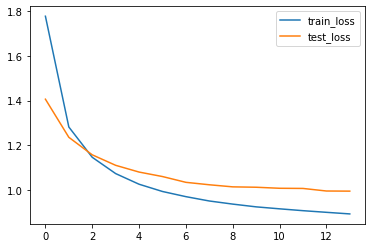

In [14]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'ddc')

In [15]:
# save the history to the csv file in log folder
history = pd.DataFrame({'train_loss': train_loss_history, 'train_acc': train_acc_history, 'test_loss': test_loss_history, 'test_acc': test_acc_history, 'train_ce_loss': train_ce_loss_history, 'test_ce_loss': test_ce_loss_history, 'train_info_loss': train_info_loss_history, 'test_info_loss': test_info_loss_history})
history.to_csv(log_dir + 'ddc_contrastive_history.csv', index=False)